# Activity 5: Improving a Model's Performance

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# get data
data = pd.read_csv('dccc_prepared.csv')

In [3]:
data.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0.080808,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,...,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0
1,0.040404,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0
2,0.040404,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,...,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0
3,0.040404,0.166667,0.666667,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.178407,0.100102,0.276367,0.002862,0.001078,0.000733,0.001610,0.002345,0.001513,0
4,0.494949,0.166667,0.666667,0.137931,0.2,0.2,0.2,0.2,0.2,0.2,...,0.671310,0.559578,0.625196,0.062961,0.023749,0.042409,0.032591,0.032237,0.026047,0


In [4]:
# seperate features and label
X = data.iloc[:,0:-1]
Y = data.iloc[:, -1]
X = X.sample(10000, random_state=0)
Y = Y.iloc[X.index.values]

# split data
x_new, x_test, y_new, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)
dev_perc = x_test.shape[0]/x_new.shape[0]
x_train, x_dev, y_train, y_dev = train_test_split(x_new, y_new, test_size=dev_perc, random_state=0)
print(x_train.shape,y_train.shape, x_dev.shape, y_dev.shape, x_test.shape, y_test.shape)

(6000, 22) (6000,) (2000, 22) (2000,) (2000, 22) (2000,)


In [5]:
# convert tensor
x_dev = torch.Tensor(x_dev.values).float()
y_dev = torch.Tensor(y_dev.values).long()

x_test = torch.Tensor(x_test.values).float()
y_test = torch.Tensor(y_test.values).long()

## Test: Increasing The Size Of The Network
We increase the number of nodes per hidden layer from 10 to 30

In [6]:
# develop model
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden1 = nn.Linear(input_size, 100)
        self.hidden2 = nn.Linear(100,100)
        self.hidden3 = nn.Linear(100, 100)
        self.hidden4 = nn.Linear(100, 50)
        self.output = nn.Linear(50,2)
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x):
        z = self.dropout(F.relu(self.hidden1(x)))
        z = self.dropout(F.relu(self.hidden2(z)))
        z = self.dropout(F.relu(self.hidden3(z)))
        z = self.dropout(F.relu(self.hidden4(z)))
        out = F.log_softmax(self.output(z), dim=1)
        
        return out

In [7]:
# setup training variables
model = SoftmaxClassifier(x_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# train
epochs= 3000
batch_size = 128

train_losses, train_acc, dev_losses, dev_acc = [],[],[],[]

for e in range(epochs):
    x_shuffle, y_shuffle = shuffle(x_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0
    for i in range(0, len(x_shuffle), batch_size):
        iterations += 1
        batch_end = i + batch_size
        
        # batches
        x_batch = torch.Tensor(x_shuffle.iloc[i:batch_end,:].values).float()
        y_batch = torch.Tensor(y_shuffle.iloc[i:batch_end].values).long()
        
        # training
        log_ps = model(x_batch)
        loss = criterion(log_ps, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
        
        # dev
        with torch.no_grad():
            dev_log_ps = model(x_dev)
            dev_loss = criterion(dev_log_ps, y_dev)
            
            dev_ps = torch.exp(dev_log_ps)
            dev_top_p, dev_top_class = dev_ps.topk(1, dim=1)
            dev_acc_score = accuracy_score(y_dev, dev_top_class)
            # add to lists
            train_losses.append(running_loss/iterations)
            dev_losses.append(dev_loss)
            train_acc.append(running_acc/iterations)
            dev_acc.append(dev_acc_score)
            
    
    print(f'e:{e+1}/{epochs}, Train Loss:{running_loss/iterations:.2f}, Dev Loss:{dev_loss:.2f}, Train Acc:{running_acc/iterations:.2f}, dev_acc:{dev_acc_score:.2f}')

e:1/3000, Train Loss:0.67, Dev Loss:0.64, Train Acc:0.59, dev_acc:0.62
e:2/3000, Train Loss:0.61, Dev Loss:0.62, Train Acc:0.67, dev_acc:0.66
e:3/3000, Train Loss:0.60, Dev Loss:0.61, Train Acc:0.68, dev_acc:0.67
e:4/3000, Train Loss:0.59, Dev Loss:0.60, Train Acc:0.69, dev_acc:0.68
e:5/3000, Train Loss:0.59, Dev Loss:0.60, Train Acc:0.69, dev_acc:0.68
e:6/3000, Train Loss:0.58, Dev Loss:0.60, Train Acc:0.70, dev_acc:0.68
e:7/3000, Train Loss:0.58, Dev Loss:0.60, Train Acc:0.70, dev_acc:0.68
e:8/3000, Train Loss:0.58, Dev Loss:0.60, Train Acc:0.70, dev_acc:0.69
e:9/3000, Train Loss:0.58, Dev Loss:0.60, Train Acc:0.70, dev_acc:0.68
e:10/3000, Train Loss:0.58, Dev Loss:0.60, Train Acc:0.70, dev_acc:0.67
e:11/3000, Train Loss:0.58, Dev Loss:0.59, Train Acc:0.70, dev_acc:0.69
e:12/3000, Train Loss:0.57, Dev Loss:0.60, Train Acc:0.71, dev_acc:0.68
e:13/3000, Train Loss:0.57, Dev Loss:0.60, Train Acc:0.71, dev_acc:0.67
e:14/3000, Train Loss:0.57, Dev Loss:0.59, Train Acc:0.71, dev_acc:0.68
e

e:226/3000, Train Loss:0.43, Dev Loss:0.75, Train Acc:0.79, dev_acc:0.69
e:227/3000, Train Loss:0.43, Dev Loss:0.71, Train Acc:0.79, dev_acc:0.70
e:228/3000, Train Loss:0.42, Dev Loss:0.74, Train Acc:0.79, dev_acc:0.68
e:229/3000, Train Loss:0.42, Dev Loss:0.70, Train Acc:0.79, dev_acc:0.69
e:230/3000, Train Loss:0.42, Dev Loss:0.76, Train Acc:0.80, dev_acc:0.69
e:231/3000, Train Loss:0.42, Dev Loss:0.75, Train Acc:0.80, dev_acc:0.69
e:232/3000, Train Loss:0.42, Dev Loss:0.74, Train Acc:0.80, dev_acc:0.70
e:233/3000, Train Loss:0.42, Dev Loss:0.71, Train Acc:0.80, dev_acc:0.69
e:234/3000, Train Loss:0.42, Dev Loss:0.75, Train Acc:0.80, dev_acc:0.68
e:235/3000, Train Loss:0.41, Dev Loss:0.72, Train Acc:0.80, dev_acc:0.68
e:236/3000, Train Loss:0.42, Dev Loss:0.70, Train Acc:0.80, dev_acc:0.69
e:237/3000, Train Loss:0.42, Dev Loss:0.77, Train Acc:0.79, dev_acc:0.69
e:238/3000, Train Loss:0.42, Dev Loss:0.72, Train Acc:0.79, dev_acc:0.69
e:239/3000, Train Loss:0.41, Dev Loss:0.73, Train A

e:450/3000, Train Loss:0.36, Dev Loss:0.77, Train Acc:0.83, dev_acc:0.70
e:451/3000, Train Loss:0.36, Dev Loss:0.84, Train Acc:0.83, dev_acc:0.70
e:452/3000, Train Loss:0.36, Dev Loss:0.78, Train Acc:0.83, dev_acc:0.68
e:453/3000, Train Loss:0.35, Dev Loss:0.83, Train Acc:0.84, dev_acc:0.69
e:454/3000, Train Loss:0.36, Dev Loss:0.81, Train Acc:0.83, dev_acc:0.69
e:455/3000, Train Loss:0.36, Dev Loss:0.82, Train Acc:0.83, dev_acc:0.69
e:456/3000, Train Loss:0.36, Dev Loss:0.85, Train Acc:0.83, dev_acc:0.70
e:457/3000, Train Loss:0.36, Dev Loss:0.79, Train Acc:0.83, dev_acc:0.69
e:458/3000, Train Loss:0.35, Dev Loss:0.88, Train Acc:0.83, dev_acc:0.69
e:459/3000, Train Loss:0.37, Dev Loss:0.84, Train Acc:0.83, dev_acc:0.69
e:460/3000, Train Loss:0.36, Dev Loss:0.86, Train Acc:0.83, dev_acc:0.70
e:461/3000, Train Loss:0.37, Dev Loss:0.84, Train Acc:0.83, dev_acc:0.68
e:462/3000, Train Loss:0.36, Dev Loss:0.76, Train Acc:0.83, dev_acc:0.70
e:463/3000, Train Loss:0.35, Dev Loss:0.80, Train A

KeyboardInterrupt: 

In [9]:
print(f'Final:\nTrain Loss:{train_losses[-1]}, Dev Loss:{dev_losses[-1]}, Train Acc:{train_acc[-1]}, dev_acc:{dev_acc[-1]}')

Final:
Train Loss:0.3150404890378316, Dev Loss:0.8959270715713501, Train Acc:0.8550347222222222, dev_acc:0.6975


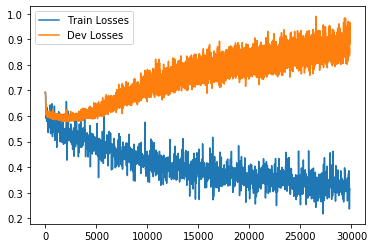

In [10]:
plt.plot(train_losses, label='Train Losses')
plt.plot(dev_losses, label='Dev Losses')
plt.legend()

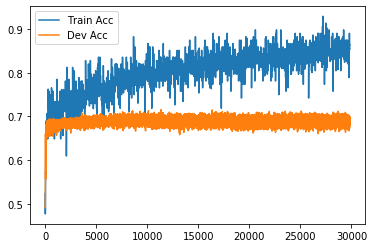

In [11]:
plt.plot(train_acc, label='Train Acc')
plt.plot(dev_acc, label='Dev Acc')
plt.legend()

In [14]:
model.eval()
test_pred = model(x_test)
test_pred = torch.exp(test_pred)
top_p, top_class_test = test_pred.topk(1, dim=1)
acc_test = accuracy_score(y_test, top_class_test)
acc_test

0.7265

In [16]:
checkpoint = {'input': x_train.shape[1],
              'state_dict': model.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')